# Практическая задача по главе XV

Постановка задачи: \
Решить задачу Дирихле в квадрате для уравнения Пуассона:
$$\frac{\partial^{2} u}{\partial x^2} + \frac{\partial^{2} u}{\partial y^2} = f(x, y),$$
$$0 \leq x \leq 1, 0 \leq y \leq 1$$
$$f(x, y) = -32(x(1-x) + y(1-y))$$
$$u(x, y) \bigg | _{x, y \in \Gamma} = 0$$

## Простая итерация с оптимальным параметром

Для системы сеточных уравнений запишем схему в виде:
$$u_{ml}^{i+1} = u_{ml}^{i} + \tau(\mathbf{\Lambda}u_{ml}^{i} - f_{ml})$$
$l \approx 2\pi^{2}, L = 8N^2$, значит оптимальный параметр $\tau$ равен $\frac{2}{l+L}$

Сетка будет с шагом $0.01$, так как более плотные сетки будут сильно хуже сходиться

In [1]:
import numpy as np
import math

In [17]:
#определим количество узлов и сетку
N = 100
space = np.zeros((N, N))

In [18]:
#определим функцию f
def f(i, j, N):
    x = float(i / N)
    y = float(j / N)
    return -32*(x*(1 - x) + y*(1-y))

In [19]:
#оператор Лапласа
def lapl(h, a, b, c, d, e):
    return ((1/h)**2)*(c - 4*b + a + d + e)

In [20]:
#определим константы тау и h
tau_opt = 2/((math.pi)**2 + 8*(N**2))
h = 1.0/N

In [21]:
#число итераций было выбрано опытным путем
for k in range(7000):
    if (((k+1) % 700) == 0):
        print(100*(k+1)/7000, 'процентов выполнено')
    res = space[5, 60]
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            space[i, j] += tau_opt*(lapl(h, space[i-1, j], space[i, j], space[i+1, j], space[i, j+1], space[i, j-1])\
                           - f(i, j, N))

10.0 процентов выполнено
20.0 процентов выполнено
30.0 процентов выполнено
40.0 процентов выполнено
50.0 процентов выполнено
60.0 процентов выполнено
70.0 процентов выполнено
80.0 процентов выполнено
90.0 процентов выполнено
100.0 процентов выполнено


In [8]:
#сохраним результат
old_space = space.copy()

In [10]:
#проведем еще итерацию чтобы посмотреть на сходимость
for i in range(1, N - 1):
        for j in range(1, N - 1):
            space[i, j] += tau_opt*(lapl(h, space[i-1, j], space[i, j], space[i+1, j], space[i, j+1], space[i, j-1])\
                           - f(i, j, N))

In [11]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import max_error

In [12]:
#определим максимальное расхождение за эту итерацию
errors = np.zeros(N)
for i in range(N):
    errors[i] = max_error(space[i], old_space[i])
print(max(errors))

9.175329324095927e-07


## Чебышевское ускорение метода простых итераций

In [13]:
#реализуем функцию, которая будет в правильном порядке организовывать корни полинома Чебышева
def arrange_knots(i):
    if (i == 1):
        return np.arange(1, 3)
    else:
        pred = arrange_knots(i-1)
        add = np.zeros(len(pred))
        for j in range(len(pred)):
            add[j] = (2**i + 1) - pred[j]
        ans = np.zeros(2*len(pred))
        for i in range(len(ans)):
            if (i % 2 == 0):
                ans[i] = pred[i // 2]
            else:
                ans[i] = add[i // 2]
        return ans

In [14]:
#напишем функцию, которая указывает какой коэффициент tau_j следует использовать
def Chebyshev_knots(it, l, L):
    knots = np.zeros(it)
    for i in range(it):
        znam = ((L + l)/2.0) + ((L-l)/2.0)*(np.cos(math.pi*(2*i+1)/(2*it)))
        knots[i] = 1.0/(znam)
    order = math.log(it, 2)
    arrange_k = arrange_knots(order)
    arrange_k = arrange_k - 1
    answer = np.zeros(len(knots))
    for i in range(len(answer)):
        index = int(arrange_k[i])
        answer[i] = knots[index]
    return answer

In [15]:
N = 100
n_space = np.zeros((N, N))

In [16]:
it = Chebyshev_knots(4096, 2*(math.pi**2), 8*(N**2))
for k in range(4096):
    if (((k+1) % 1024) == 0):
        print(100*(k+1)/4096, 'процентов выполнено')
    tau = tau_opt
    for i in range(1, N - 1):
        for j in range(1, N - 1):
            n_space[i, j] += tau*(lapl(h, n_space[i-1, j], n_space[i, j], n_space[i+1, j], \
                                       n_space[i, j+1], n_space[i, j-1]) - f(i, j, N))

25.0 процентов выполнено
50.0 процентов выполнено
75.0 процентов выполнено
100.0 процентов выполнено


In [17]:
old_n_space = n_space.copy()

In [18]:
for i in range(1, N - 1):
        for j in range(1, N - 1):
            tau = it[511]
            n_space[i, j] += tau*(lapl(h, n_space[i-1, j], n_space[i, j], n_space[i+1, j], \
                                       n_space[i, j+1], n_space[i, j-1]) - f(i, j, N))

In [19]:
errors = np.zeros(N)
for i in range(N):
    errors[i] = max_error(n_space[i], old_n_space[i])
print(max(errors))

0.002896641222587334


Как видно, метод также сходится

## Визуализация решения

In [20]:
import matplotlib as mpl
from matplotlib import pyplot

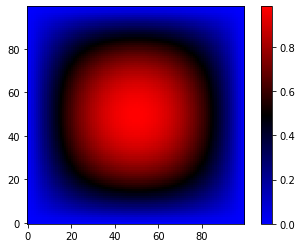

In [22]:
fig = pyplot.figure(2)

cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

img2 = pyplot.imshow(space,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.colorbar(img2,cmap=cmap2)

fig.savefig("image2.png")

## Точное решение

In [14]:
N = 100
c_space = np.zeros((N, N))

In [15]:
for i in range(N):
    for j in range(N):
        x = float(i/N)
        y = float(j/N)
        c_space[i, j] = 16*x*(1-x)*y*(1-y) 

In [12]:
import matplotlib as mpl
from matplotlib import pyplot

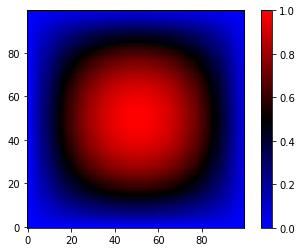

In [16]:
fig = pyplot.figure(2)

cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                           ['blue','black','red'],
                                           256)

img2 = pyplot.imshow(c_space,interpolation='nearest',
                    cmap = cmap2,
                    origin='lower')

pyplot.colorbar(img2,cmap=cmap2)

fig.savefig("image2.png")

In [23]:
print(np.linalg.norm(space-c_space))

1.9067943094266648
